# Preparing and Checking Data

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# Composition of Dataloader

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# Processing Data

In [5]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [7]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100, 2) ))

pad_sequences maxlen :  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다. 


# Adding Padding using keras.preprocessing.sequence.pad_sequences 

In [8]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

In [9]:
# 문장길이의 평균값, 최대값, 표준편차를 다시 계산해본다.
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0


# Composing Model and Validation Set

## 1-D CNN Model

In [10]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

Cnn_model = keras.Sequential()
Cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
Cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Cnn_model.add(keras.layers.MaxPooling1D(5))
Cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Cnn_model.add(keras.layers.GlobalMaxPooling1D())
Cnn_model.add(keras.layers.Dense(8, activation='relu'))
Cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

Cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

##  Word2Vec Model

In [11]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

## Embedding Matrix

In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [13]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
Embed_model = keras.Sequential()
Embed_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
Embed_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Embed_model.add(keras.layers.MaxPooling1D(5))
Embed_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Embed_model.add(keras.layers.GlobalMaxPooling1D())
Embed_model.add(keras.layers.Dense(8, activation='relu'))
Embed_model.add(keras.layers.Dense(1, activation='sigmoid')) 

Embed_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## Validation Set

In [14]:
# 3:2의 비율로 train 과 valid 데이터를 나눠줍니다.
# validation set 60000건 분리
X_val = X_train[:60000]   
y_val = y_train[:60000]

# validation set을 제외한 나머지 86182건
partial_X_train = X_train[60000:]  
partial_y_train = y_train[60000:]

print(X_train.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(146182, 41)
(86182, 41)
(86182,)
(60000, 41)
(60000,)


# Model Training

## 1-D CNN Model

In [15]:
Cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

Cnn_history = Cnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
169/169 [==============================] - 4s 7ms/step - loss: 0.5475 - accuracy: 0.7132 - val_loss: 0.3727 - val_accuracy: 0.8366
Epoch 2/20
169/169 [==============================] - 1s 5ms/step - loss: 0.3395 - accuracy: 0.8546 - val_loss: 0.3487 - val_accuracy: 0.8478
Epoch 3/20
169/169 [==============================] - 1s 6ms/step - loss: 0.2987 - accuracy: 0.8754 - val_loss: 0.3471 - val_accuracy: 0.8494
Epoch 4/20
169/169 [==============================] - 1s 5ms/step - loss: 0.2689 - accuracy: 0.8906 - val_loss: 0.3528 - val_accuracy: 0.8493
Epoch 5/20
169/169 [==============================] - 1s 5ms/step - loss: 0.2387 - accuracy: 0.9056 - val_loss: 0.3643 - val_accuracy: 0.8474
Epoch 6/20
169/169 [==============================] - 1s 5ms/step - loss: 0.2069 - accuracy: 0.9222 - val_loss: 0.3855 - val_accuracy: 0.8452
Epoch 7/20
169/169 [==============================] - 1s 5ms/step - loss: 0.1744 - accuracy: 0.9371 - val_loss: 0.4196 - val_accuracy: 0.8424
Epoch 

In [16]:
results = Cnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 1.0091 - accuracy: 0.8118
[1.0090889930725098, 0.8118477463722229]


## Embed Model

In [17]:
Embed_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

Embed_history = Embed_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
169/169 [==============================] - 2s 11ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5019
Epoch 2/20
169/169 [==============================] - 1s 9ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6939 - val_accuracy: 0.4981
Epoch 3/20
169/169 [==============================] - 1s 9ms/step - loss: 0.6891 - accuracy: 0.5296 - val_loss: 0.6728 - val_accuracy: 0.5915
Epoch 4/20
169/169 [==============================] - 1s 9ms/step - loss: 0.4793 - accuracy: 0.7766 - val_loss: 0.3936 - val_accuracy: 0.8235
Epoch 5/20
169/169 [==============================] - 1s 9ms/step - loss: 0.3427 - accuracy: 0.8533 - val_loss: 0.3693 - val_accuracy: 0.8381
Epoch 6/20
169/169 [==============================] - 1s 9ms/step - loss: 0.3027 - accuracy: 0.8749 - val_loss: 0.3787 - val_accuracy: 0.8367
Epoch 7/20
169/169 [==============================] - 1s 9ms/step - loss: 0.2746 - accuracy: 0.8897 - val_loss: 0.3720 - val_accuracy: 0.8409
Epoch

In [18]:
results = Embed_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7028 - accuracy: 0.8097
[0.7028336524963379, 0.8096913695335388]


# Loss Accuracy Visualization

## 1-D CNN Model

In [19]:
Cnn_history_dict = Cnn_history.history
print(Cnn_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


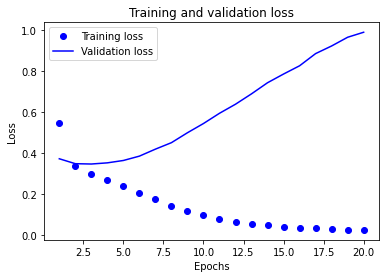

In [20]:
import matplotlib.pyplot as plt

acc = Cnn_history_dict['accuracy']
val_acc = Cnn_history_dict['val_accuracy']
loss = Cnn_history_dict['loss']
val_loss = Cnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

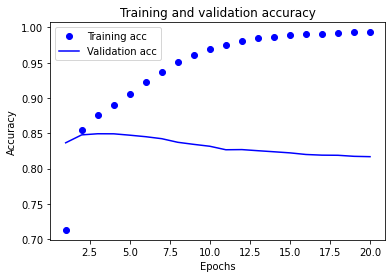

In [21]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Embed Model

In [22]:
Embed_history_dict = Embed_history.history
print(Embed_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


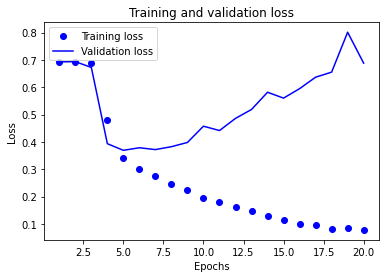

In [23]:
acc = Embed_history_dict['accuracy']
val_acc = Embed_history_dict['val_accuracy']
loss = Embed_history_dict['loss']
val_loss = Embed_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

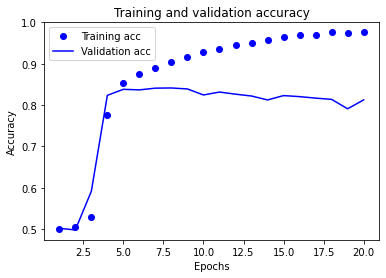

In [24]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 한국어 Word2Vec 임베딩 활용하여 성능개선

In [25]:
import gensim 
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings(action='ignore')

In [26]:
pip install --upgrade gensim==3.8.3

Note: you may need to restart the kernel to use updated packages.


In [27]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['집']
vector     

array([-1.319586  , -1.6629723 ,  0.1505883 ,  0.5035253 , -2.6690226 ,
       -1.0570946 ,  0.67788476,  2.796687  ,  1.4200262 , -0.39614034,
        1.9018966 ,  2.9973626 , -0.01318461,  0.35922977,  1.4223385 ,
        0.40999603, -0.42552626,  0.31498262,  0.87282205, -1.3778601 ,
       -0.1918586 ,  0.9000629 , -1.8640414 ,  0.8167136 , -1.7011755 ,
       -0.98501635,  0.66861403, -0.9031406 ,  0.3020793 ,  2.0629468 ,
       -0.31631446, -0.7964669 ,  0.11580559, -0.9859846 ,  0.7692624 ,
       -0.19869252,  0.56788325,  2.29683   ,  1.1519096 ,  1.5394832 ,
       -1.0729129 ,  0.1502994 ,  1.2680385 , -2.249592  , -0.8000674 ,
       -0.20292565, -0.40892753, -0.5215352 , -0.507804  , -1.3664671 ,
        0.42219886, -0.31854075,  0.2340286 , -0.77383935, -1.5936835 ,
        0.01904743,  1.177212  ,  1.6091572 , -0.5099399 ,  1.9581834 ,
       -0.34881008,  0.37763453, -0.01511123, -0.58241713,  0.40495008,
        0.8804171 ,  0.1846361 ,  1.0777823 , -0.7750021 , -1.00

In [28]:
word2vec.similar_by_word("행복")

[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

## Model

In [30]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
LSTM_UNITS = 196
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

# 모델 구성
kor_model = keras.Sequential()
kor_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
kor_model.add(keras.layers.SpatialDropout1D(0.4))
# kor_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
# kor_model.add(keras.layers.MaxPooling1D(5))
# kor_model.add(keras.layers.Dropout(0.2))
# kor_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
# kor_model.add(keras.layers.GlobalMaxPooling1D())
# kor_model.add(keras.layers.Dropout(0.2))
kor_model.add(keras.layers.LSTM(LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))  
kor_model.add(keras.layers.LSTM(LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))  
kor_model.add(keras.layers.MaxPooling1D())
kor_model.add(keras.layers.GlobalMaxPooling1D())
kor_model.add(keras.layers.Dense(DENSE_HIDDEN_UNITS, activation='relu'))
kor_model.add(keras.layers.Dense(DENSE_HIDDEN_UNITS, activation='relu'))

kor_model.add(keras.layers.Dense(1, activation='sigmoid')) 

kor_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 41, 200)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 41, 196)           311248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 41, 196)           308112    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 196)           0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 196)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

## Training

In [31]:
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

kor_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

kor_history = kor_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
337/337 [==============================] - 119s 342ms/step - loss: 0.5423 - accuracy: 0.7153 - val_loss: 0.4337 - val_accuracy: 0.7983
Epoch 2/10
337/337 [==============================] - 114s 338ms/step - loss: 0.4187 - accuracy: 0.8041 - val_loss: 0.3658 - val_accuracy: 0.8334
Epoch 3/10
337/337 [==============================] - 114s 338ms/step - loss: 0.3741 - accuracy: 0.8303 - val_loss: 0.3463 - val_accuracy: 0.8458
Epoch 4/10
337/337 [==============================] - 114s 338ms/step - loss: 0.3443 - accuracy: 0.8457 - val_loss: 0.3433 - val_accuracy: 0.8482
Epoch 5/10
337/337 [==============================] - 114s 339ms/step - loss: 0.3258 - accuracy: 0.8563 - val_loss: 0.3292 - val_accuracy: 0.8566
Epoch 6/10
337/337 [==============================] - 114s 339ms/step - loss: 0.3113 - accuracy: 0.8635 - val_loss: 0.3328 - val_accuracy: 0.8590
Epoch 7/10
337/337 [==============================] - 115s 340ms/step - loss: 0.2999 - accuracy: 0.8701 - val_loss: 0.3327 -

## Loss Accuracy Graph

In [32]:
kor_history_dict = kor_history.history
print(kor_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


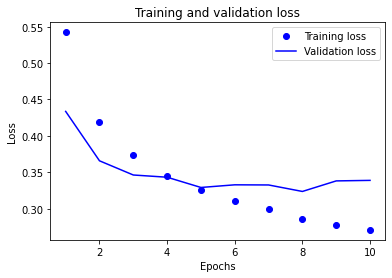

In [33]:
acc = kor_history_dict['accuracy']
val_acc = kor_history_dict['val_accuracy']
loss = kor_history_dict['loss']
val_loss = kor_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

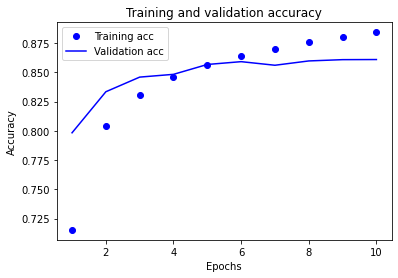

In [34]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()